Importing Required Libraries

In [1]:
import os, json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, classification_report,f1_score, confusion_matrix, ConfusionMatrixDisplay,classification_report)
from sklearn.dummy import DummyClassifier 
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
import joblib

#Creating Folders for Saving Resiults
os.makedirs('artifacts', exist_ok=True)
os.makedirs('models', exist_ok=True)


Loading the Cleaned Dataset 

In [9]:
df=pd.read_csv(r'C:\Users\CKB ENT\Desktop\Machine Learning and AI\Internship\Thrive_Internship_ML_A\customer_support_tickets_clean_500 (3).csv')
print("Dataset Loaded Successfully")
print(f"Dataset Shape: {df.shape}")
df.head()

Dataset Loaded Successfully
Dataset Shape: (520, 4)


,text,label,ticket_id,agent_name
0,Where can I find API rate limits documentation?,Other,1000,Dana
1,Can I migrate data from Freshdesk?,Other,1001,Bob
2,Cannot update billing address page keeps reloa...,Billing,1002,Charlie
3,Looking for a product roadmap or upcoming feat...,Other,1003,Dana
4,Dark mode toggled but UI stays light.,Technical,1004,Alice


Splitting the Data Set

In [10]:
X = df["text"]; y = df["label"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
print("Train/test sizes:", len(X_train), len(X_test))



Train/test sizes: 416 104


Model Training

Training Majority ...
Majority: Accuracy=0.250, Weighted F1=0.100
Training Log_Reg ...
Log_Reg: Accuracy=0.827, Weighted F1=0.861
Training TFIDF_LogReg ...
TFIDF_LogReg: Accuracy=0.779, Weighted F1=0.831
Training TFIDF_NB ...
TFIDF_NB: Accuracy=0.904, Weighted F1=0.881
Training BOW_NB ...
BOW_NB: Accuracy=0.923, Weighted F1=0.909
Training TFIDF_LinearSVC ...
TFIDF_LinearSVC: Accuracy=0.885, Weighted F1=0.871

Comparison:


,Model,Accuracy,Weighted_F1,Note
4,BOW_NB,0.923077,0.909462,CountVectorizer + MultinomialNB
3,TFIDF_NB,0.903846,0.881177,TF-IDF + MultinomialNB
5,TFIDF_LinearSVC,0.884615,0.871219,TF-IDF + LinearSVC
1,Log_Reg,0.826923,0.861209,Logistic Regression on raw text (no vectorizat...
2,TFIDF_LogReg,0.778846,0.830881,TF-IDF + Logistic Regression
0,Majority,0.250000,0.100000,Predicts the most frequent label.



Best model: BOW_NB

Detailed eval for best model (BOW_NB):
              precision    recall  f1-score   support

     Account       0.89      1.00      0.94        24
     Billing       1.00      0.96      0.98        24
       Other       0.93      1.00      0.96        26
   Technical       0.96      0.92      0.94        25
     unknown       0.00      0.00      0.00         5

    accuracy                           0.92       104
   macro avg       0.76      0.78      0.76       104
weighted avg       0.90      0.92      0.91       104



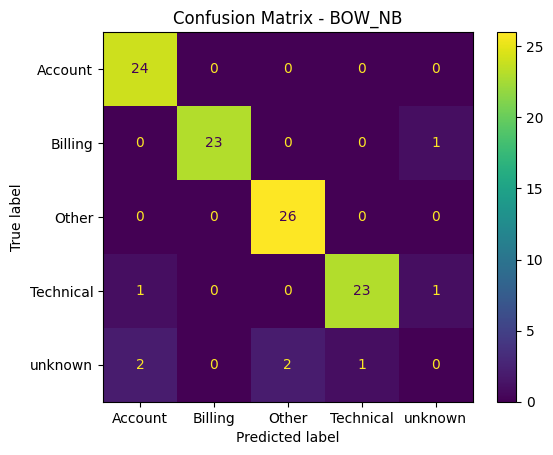


Artifacts saved to: artifacts
Models saved to: models


In [15]:
# Model definitions
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline

# Ensure path variables exist (folders already created in an earlier cell)
artifacts_dir = 'artifacts'
models_dir = 'models'
# legacy name used elsewhere in the notebook
artifacts = artifacts_dir

models = {
    'Majority': DummyClassifier(strategy="most_frequent"),
    # Wrap logistic regression in a vectorizer pipeline so text is converted to numeric features
    'Log_Reg': make_pipeline(CountVectorizer(ngram_range=(1,2), max_features=20000, stop_words='english'), LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)),
    'TFIDF_LogReg': make_pipeline(TfidfVectorizer(ngram_range=(1,2), max_features=20000, stop_words='english'), LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)),
    'TFIDF_NB': make_pipeline(TfidfVectorizer(ngram_range=(1,2), max_features=20000, stop_words='english'), MultinomialNB()),
    'BOW_NB': make_pipeline(CountVectorizer(ngram_range=(1,2), max_features=15000, stop_words='english'), MultinomialNB()),
    'TFIDF_LinearSVC': make_pipeline(TfidfVectorizer(ngram_range=(1,2), max_features=20000, stop_words='english'), LinearSVC(max_iter=10000, class_weight='balanced', random_state=42))
}

notes = {
    'Majority': "Predicts the most frequent label.",
    'Log_Reg': "Logistic Regression on raw text (no vectorization).",
    'TFIDF_LogReg': "TF-IDF + Logistic Regression",
    'TFIDF_NB': "TF-IDF + MultinomialNB",
    'BOW_NB': "CountVectorizer + MultinomialNB",
    'TFIDF_LinearSVC': "TF-IDF + LinearSVC"
}

results = {}
fitted = {}

for name, model in models.items():
    print(f"Training {name} ...")
    if name == 'Majority':
        model.fit(np.zeros((len(y_train),1)), y_train)
        y_pred = model.predict(np.zeros((len(y_test),1)))
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1w = f1_score(y_test, y_pred, average='weighted')
    results[name] = {'accuracy': float(acc), 'weighted_f1': float(f1w), 'note': notes[name]}
    fitted[name] = model
    print(f"{name}: Accuracy={acc:.3f}, Weighted F1={f1w:.3f}")

# Save metrics and comparison
metrics_file = os.path.join(artifacts_dir, "baseline_metrics.json")
with open(metrics_file, "w") as f:
    json.dump(results, f, indent=2)

comp = pd.DataFrame([{'Model':k, 'Accuracy':v['accuracy'], 'Weighted_F1':v['weighted_f1'], 'Note':v['note']} for k,v in results.items()]).sort_values('Weighted_F1', ascending=False)
comp.to_csv(os.path.join(artifacts_dir, "baseline_comparison.csv"), index=False)

# Save models
for name, obj in fitted.items():
    joblib.dump(obj, os.path.join(models_dir, f"{name}.joblib"))

print("\nComparison:")
display(comp)

best = comp.iloc[0]['Model']
print("\nBest model:", best)

# Show classification report and confusion matrix for best
print(f"\nDetailed eval for best model ({best}):")
if best == 'Majority':
    y_pred_best = fitted[best].predict(np.zeros((len(y_test),1)))
else:
    y_pred_best = fitted[best].predict(X_test)

print(classification_report(y_test, y_pred_best, zero_division=0))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_best)
plt.title(f"Confusion Matrix - {best}")
plt.show()

print("\nArtifacts saved to:", artifacts_dir)
print("Models saved to:", models_dir)